# Model Training and Inference Walkthrough

## Dataset Preparation

**Example Case**: Cavity Flow
- Non-dimensional
- Cell Centre Values
- Boundary Values added too

In [26]:
import matplotlib.pyplot  as plt
import numpy as np

In [27]:
# Example Cavity Flow dataset:
dataset_path = r'C:\Users\Noahc\Documents\USYD\tutorial\python_utils\cavity_with_bc_normalized.npy'
dataset = np.load(dataset_path, allow_pickle=True).item()

Dataset object has the following structure:

In [28]:
dataset.keys()

dict_keys(['Solutions', 'Re', 'Points', 'Boundary', 'Boundary Points'])

In [29]:
dataset['Solutions'].shape

(200, 65536, 3)

In [30]:
dataset['Points'].shape

(65536, 2)

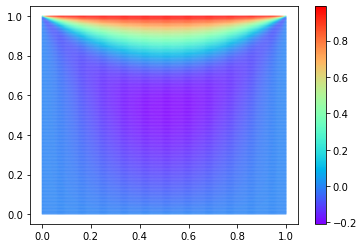

In [31]:
batch = 0
plt.figure()
cm = plt.cm.get_cmap('rainbow')
plt.scatter(dataset['Points'][:,0], dataset['Points'][:,1], c=dataset['Solutions'][batch,:,0], cmap=cm,s=0.1)
plt.colorbar()
plt.show()

As dataset is a list of points, irregular grids can also be loaded.

In [32]:
# Example Step Flow dataset:
dataset_path_2 = r'C:\Users\Noahc\Documents\USYD\tutorial\python_utils\backward_facing_step_normalized.npy'
dataset_2 = np.load(dataset_path_2, allow_pickle=True).item()

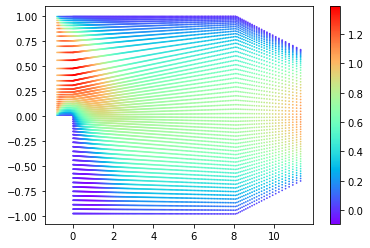

In [33]:
batch = 0
plt.figure()
cm = plt.cm.get_cmap('rainbow')
plt.scatter(dataset_2['Points'][:,0], dataset_2['Points'][:,1], c=dataset_2['Solutions'][batch,:,0], cmap=cm,s=0.5)
plt.colorbar()
plt.show()

### Dataset Preparation for Model
- Split dataset into batches of different cases
- Unit Normalize data
- Shuffle coordinates order
- Subsample number of Coordinates

In [34]:
from data_utils.dataset_prep import create_loader, prepare_dataset

lets get some default arguments:

In [46]:
dataset_args = dict()
dataset_args['name']        = 'Cavity'
dataset_args['L']           = 1.0
dataset_args['sub_x']       = 0.10
dataset_args['normalize_y'] = True
dataset_args['normalize_x'] = True
dataset_args['normalize_f'] = True
dataset_args['file_path'] = dataset_path
dataset_args['inference']   = True
dataset_args['train_ratio'] = 0.7
dataset_args['seed']        = 42
dataset_args['batchsize']   = 4
dataset_args['random_coords'] = True
dataset_args['train'] = True
dataset_args['bc_input_f']    = False

In [47]:
dataset = prepare_dataset(dataset_args, unsupervised=False)
torch_dataset = create_loader(dataset, dataset_args)


Calculating Step Dataset Normalizers
Dataset loaded has the following keys:  dict_keys(['Solutions', 'Re', 'Points', 'Boundary', 'Boundary Points'])
Reynolds Number Range: 5.0-1000.0
Total Cases: 200
Total Internal Cells: 65536 (before any subsampling)
Patch Names: dict_keys(['movingWall', 'fixedWalls'])
Total Boundary Cells: 1026

    Queries Normalized with Means: tensor([[0.5000, 0.5000]], dtype=torch.float64) and Stds: tensor([[0.2909, 0.2909]], dtype=torch.float64)
    Solutions Normalized with Means: tensor([[ 3.8658e-03,  6.6292e-07, -3.3446e-02]], dtype=torch.float64) and Stds: tensor([[0.2222, 0.1852, 0.2010]], dtype=torch.float64)
    Re Keys Normalized with Means: tensor([502.5000]) and Stds: tensor([289.3959])

Total Internal Cells reduced by 58983 to: 7579 (after subsampling)

Creating Dataloader:
    Dataset Split up for inference using torch generator seed: 42
    Training Dataset Selected


In [48]:
from torch.utils.data import DataLoader
train_loader = DataLoader(
                        dataset=torch_dataset,
                        batch_size=dataset_args['batchsize'],
                        shuffle=True
                    )

Get first batch of data:
- `x` - Input coordinates (Cartesian X,Y)
- `x_i` - Input Keys (Reynolds Number)
- `y` - Ground Truth Solution (U,V,P)
- `index` - Array indices of Boundary Points

In [49]:
x, x_i, y, index = next(iter(train_loader))

Now the dataset is also subsampled to ~10% of the coordinates of the original

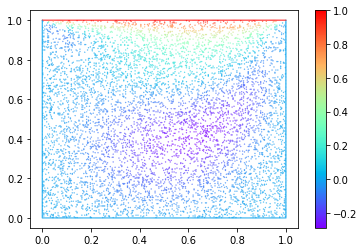

In [50]:
batch = 0
plt.figure()
cm = plt.cm.get_cmap('rainbow')
plt.scatter(x[batch,:,0], x[batch,:,1], c=y[batch,:,0], cmap=cm,s=0.1)
plt.colorbar()
plt.show()

## Inference

lets set up some model hyper-parameters

In [16]:
model_args = dict()
model_args['trunk_size']        = 2
model_args['theta_size']        = 0
model_args['branch_sizes']      = [1]
model_args['output_size']       = 3
model_args['n_head']            = 1
model_args['attn_type']         = 'linear'
model_args['ffn_dropout']       = 0.0
model_args['attn_dropout']      = 0.0
model_args['mlp_layers']        = 2
model_args['act']               = 'gelu'
model_args['hfourier_dim']      = 0
model_args['gating']            = True
model_args['init_w']            = False
model_args['n_layers']          = 2
model_args['n_hidden']          = 20

In [51]:
from models.old_model import CGPTNO
model = CGPTNO(branch_sizes=torch_dataset.config['branch_sizes'],
                n_layers=model_args['n_layers'],
                n_hidden=model_args['n_hidden'])

Additionally, for Autograd Physics informed training, the model needs to be wrapped. This is because autograd calculates the gradient of the output (U,V,P) relative to the input (X,Y). However, as we have performed normalization on the output and input, these need to be un-normalized to retrieve real gradients. This is best done in the wrapping of the model. 

Without wrapping:
$$ \frac{\partial U}{\partial x} \ne \text{F}(U_{normalized}, x_{normalized}) $$

With wrapping:
$$ \frac{\partial U}{\partial x} = \text{F}(U_{real}, x_{real}) $$



In [52]:
from train_utils.navier_stokes_autograd import wrapped_model
model = wrapped_model(model=model, query_normalizer=dataset.x_normalizer)

#### Loading in a pretrained model

In [53]:
import torch
case_path = r'C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\analytics_v2_Retiro\test_aTrain_b0_c1_d0.8_h0.7.pt'
ckpt = torch.load(case_path, map_location='cpu')
model.load_ckpt(ckpt['model'])

Checkpoint Loaded


In [54]:
model.eval
out = model(x=x,inputs=x_i).detach().numpy()

**Prediction**:

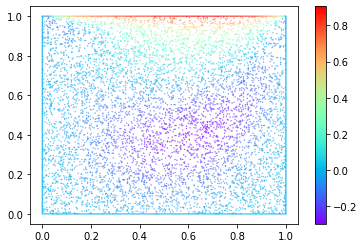

In [55]:
batch = 0
plt.figure()
cm = plt.cm.get_cmap('rainbow')
plt.scatter(x[batch,:,0], x[batch,:,1], c=out[batch,:,0], cmap=cm,s=0.1)
plt.colorbar()
plt.show()

While this model was trained on 80% coordinate density of the dataset. We can infer at 100% easily on CPU:

In [56]:
dataset_args['sub_x'] = 1.0 #(100% coordinate density)
dataset_3 = prepare_dataset(dataset_args, unsupervised=False)
torch_dataset_3 = create_loader(dataset_3, dataset_args)
train_loader_3 = DataLoader(
                        dataset=torch_dataset_3,
                        batch_size=dataset_args['batchsize'],
                        shuffle=True
                    )
x, x_i, y, index = next(iter(train_loader_3))


Calculating Step Dataset Normalizers
Dataset loaded has the following keys:  dict_keys(['Solutions', 'Re', 'Points', 'Boundary', 'Boundary Points'])
Reynolds Number Range: 5.0-1000.0
Total Cases: 200
Total Internal Cells: 65536 (before any subsampling)
Patch Names: dict_keys(['movingWall', 'fixedWalls'])
Total Boundary Cells: 1026

    Queries Normalized with Means: tensor([[0.5000, 0.5000]], dtype=torch.float64) and Stds: tensor([[0.2909, 0.2909]], dtype=torch.float64)
    Solutions Normalized with Means: tensor([[ 3.8658e-03,  6.6292e-07, -3.3446e-02]], dtype=torch.float64) and Stds: tensor([[0.2222, 0.1852, 0.2010]], dtype=torch.float64)
    Re Keys Normalized with Means: tensor([502.5000]) and Stds: tensor([289.3959])

Creating Dataloader:
    Dataset Split up for inference using torch generator seed: 42
    Training Dataset Selected


In [57]:
model.eval
out = model(x=x,inputs=x_i).detach().numpy()

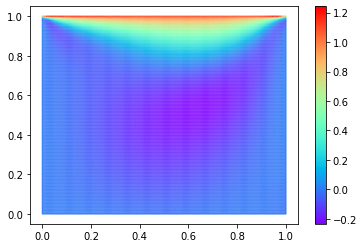

In [58]:
batch = 0
plt.figure()
cm = plt.cm.get_cmap('rainbow')
plt.scatter(x[batch,:,0], x[batch,:,1], c=out[batch,:,0], cmap=cm,s=0.1)
plt.colorbar()
plt.show()

## Training
Functionalities:

1. Traditional Training
2. Hybrid Training (Pointwise + PDE + BC)
3. Key Only Batches (Unsupervised)
4. Dynamic Loss balancing for Hybrid Training
5. Changing of model depth etc.

In [59]:
file_path=r'C:\Users\Noahc\Documents\USYD\tutorial\python_utils\cavity_with_bc_normalized.npy'
!python main_step.py --epochs 1 --sub_x 0.001 --batch_size 4 --seed 42 --path {file_path} --data_name "Cavity" --Hybrid_type "Monitor" --n_hidden 20 --layers 2 --datasplit 0.1



The following code snippets have been run.

    os.environ['PYTHONHASHSEED'] = str(42)
    numpy.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    

Calculating Step Dataset Normalizers
Dataset loaded has the following keys:  dict_keys(['Solutions', 'Re', 'Points', 'Boundary', 'Boundary Points'])
Reynolds Number Range: 5.0-1000.0
Total Cases: 200
Total Internal Cells: 65536 (before any subsampling)
Patch Names: dict_keys(['movingWall', 'fixedWalls'])
Total Boundary Cells: 1026

    Queries Normalized with Means: tensor([[0.5000, 0.5000]], dtype=torch.float64) and Stds: tensor([[0.2909, 0.2909]], dtype=torch.float64)
    Solutions Normalized with Means: tensor([[ 3.8658e-03,  6.6292e-07, -3.3446e-02]], dtype=torch.float64) and Stds: tensor([[0.2222, 0.1852, 0.2010]], dtype=torch.float64)
    Re Keys